In [1]:
import numpy as np
import pandas as pd
import scipy
import itertools
import time
import sys
import datetime
import os

from kesi._verbose import (VerboseFFR,
                           LinearMixture,
                           LoadableVerboseFFR)
from kesi._engine import _LinearKernelSolver
sys.path.append('..')
from FEM.fem_sphere_gaussian import (SomeSphereGaussianSourceFactory3D,
                                     SomeSphereGaussianSourceFactoryOnlyCSD)
from _common_new import altitude_azimuth_mesh

try:
    from joblib import Parallel, delayed
    import multiprocessing
    NUM_CORES = multiprocessing.cpu_count() - 1
    PARALLEL_AVAILABLE = True
except ImportError:
    PARALLEL_AVAILABLE = False

MeasurementManagerBase = VerboseFFR.MeasurementManagerBase

Unable to import from dolfin


In [2]:
import matplotlib.pyplot as plt

In [3]:
def makemydir(directory):
    """
    Creates directory if it doesn't exist
    """
    try:
        os.makedirs(directory)
    except OSError:
        pass
    os.chdir(directory)

In [4]:
class MeasurementManager(MeasurementManagerBase):
    def __init__(self, ELECTRODES, space='potential'):
        self._space = space
        self._ELECTRODES = ELECTRODES
        self.number_of_measurements = len(ELECTRODES)
    def probe(self, field):
        return getattr(field, 
                       self._space)(self._ELECTRODES.X,
                                    self._ELECTRODES.Y,
                                    self._ELECTRODES.Z)

In [5]:
def all_sources(r, altitude, azimuth):
    return [factory(x, y, z)
            for x, y, z in itertools.product(r, altitude, azimuth)]

In [6]:
def calculate_point_error(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction at every point of
    estimation space separetly.

    Parameters
    ----------
    true_csd: numpy array
        Values of true csd at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.

    Returns
    -------
    point_error: numpy array
        Normalized error of reconstruction calculated separetly at every
        point of estimation space.
    """
    true_csd_r = true_csd.reshape(true_csd.size, 1)
    est_csd_r = est_csd.reshape(est_csd.size, 1)
    epsilon = np.linalg.norm(true_csd_r)/np.max(abs(true_csd_r))
    err_r = abs(est_csd_r/(np.linalg.norm(est_csd_r)) -
                true_csd_r/(np.linalg.norm(true_csd_r)))
    err_r *= epsilon
    point_error = err_r.reshape(true_csd.shape)
    return point_error

In [7]:
def calculate_rms(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rms: float
        Normalized error of reconstruction.
    """
    rms = np.linalg.norm((true_csd - est_csd))/(np.linalg.norm(true_csd))
    return rms

In [8]:
def calculate_rdm(true_csd, est_csd):
    """
    Calculates relative difference measure between reconstructed source and
    ground truth.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rdm: float
        Relative difference measure.
    """
    epsilon = np.finfo(np.float64).eps
    rdm = np.linalg.norm(est_csd/(np.linalg.norm(est_csd) + epsilon) -
                         true_csd/(np.linalg.norm(true_csd) + epsilon))
    return rdm

In [9]:
def calculate_rdm_point(true_csd, est_csd):
    rdm = abs(est_csd.reshape(est_csd.size, 1)/(np.linalg.norm(est_csd.reshape(est_csd.size, 1))) -
              true_csd.reshape(true_csd.size, 1)/(np.linalg.norm(true_csd.reshape(true_csd.size, 1))))
    rdm *= np.linalg.norm(true_csd.reshape(true_csd.size, 1))/np.max(abs(true_csd.reshape(true_csd.size, 1)))
    return rdm.reshape(true_csd.shape)

In [10]:
def calculate_mag(true_csd, est_csd):
    """
    Calculates magnitude ratio between reconstructed source and ground
    truth.
    Parameters
    ----------
    test_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    mag: float
        Magnitude ratio.
    """
    epsilon = np.finfo(np.float64).eps
    mag = np.linalg.norm(est_csd/(true_csd + epsilon))
    return mag

In [11]:
def calculate_mag_point(true_csd, est_csd):
    epsilon = np.max(abs(true_csd.reshape(true_csd.size, 1)))
    mag = abs(est_csd.reshape(est_csd.size, 1))/(abs(true_csd.reshape(true_csd.size, 1)) + epsilon)
    return mag.reshape(true_csd.shape)

In [12]:
def cross_validation(reconstructor, measurements, regularization_parameters):
    EE = np.zeros((regularization_parameters.size, np.array(measurements).shape[0]))
    for rp_idx, rp in enumerate(regularization_parameters):
        print('Cross validating regularization parameter :', rp)
        EE[rp_idx] = np.linalg.norm(reconstructor.leave_one_out_errors(np.array(measurements).T, rp), axis=0)
    indx_rp = np.argmin(EE, axis=0)
    return indx_rp, EE

In [13]:
def estimate_csd(reconstructor, measurements, regularization_parameters):
    indx_rp, EE = cross_validation(reconstructor, measurements, regularization_parameters)
    if np.array(measurements).shape[0] == np.array(measurements).size:
        indx_rp = indx_rp[0]
        EST_CSD = reconstructor(np.array(measurements).T, regularization_parameters[indx_rp]).T
        EE = EE[:, 0]
        lambd = regularization_parameters[indx_rp]
        print('CV_rp :', regularization_parameters[indx_rp])
    else:
        EST_CSD = np.zeros(((np.array(measurements).shape[0]), reconstructor._cross_kernel.shape[0]))
        lambd = np.zeros([(np.array(measurements).shape[0])])
        for i, rp in enumerate(regularization_parameters):
            lambd[indx_rp == i] = rp
            EST_CSD[indx_rp == i, :] = reconstructor(np.array(measurements)[indx_rp == i, :].T, rp).T
    return EST_CSD, indx_rp, EE, rp

In [14]:
def generate_EEG_electrodesRPI(nr_theta, nr_phi, r):
    '''Determine positions of electrodes - EEG
    '''
    theta, phi, r = np.meshgrid(np.linspace(-0.5*np.pi, 0.5*np.pi, nr_theta),
                                np.linspace(0, 2*np.pi, nr_phi),
                                r)
    ELE_X = -r*np.cos(theta)*np.cos(phi)
    ELE_Y = r*np.cos(theta)*np.sin(phi)
    ELE_Z = r*np.sin(theta)
    ELECTRODES = pd.DataFrame({'X': ELE_X.flatten(),
                               'Y': ELE_Y.flatten(),
                               'Z': ELE_Z.flatten()})
    ELECTRODES_NR = ELE_X.size
    return ELECTRODES, ELECTRODES_NR

def generate_ECoG_electrodes(nr_x, nr_y, Z):
    '''Determine positions of electrodes - ECoG
    '''
    xx, yy, zz = np.meshgrid(np.linspace(-0.035, 0.035, nr_x),
                             np.linspace(-0.035, 0.035, nr_y),
                             [-Z])
    ELE_PLANE = np.zeros([xx.size, 3])
    ELE_PLANE[:, 0] = xx.flatten()
    ELE_PLANE[:, 1] = yy.flatten()
    ELE_PLANE[:, 2] = zz.flatten()
    ELE_SPHERE = np.array([Z*ELE_PLANE[i]/np.linalg.norm(ELE_PLANE[i]) for i in range(xx.size)])
    ELECTRODES = pd.DataFrame({'X': ELE_SPHERE[:, 0],
                               'Y': ELE_SPHERE[:, 1],
                               'Z': ELE_SPHERE[:, 2]})
    ELECTRODES_NR = xx.size
    return ELECTRODES, ELECTRODES_NR

In [15]:
def calculate_eigensources(kernel, cross_kernel, regularization_parameter=0):
    eigenvalues, eigenvectors = np.linalg.eigh(kernel + np.identity(kernel.shape[0])
                                               * regularization_parameter)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return np.matmul(cross_kernel, eigenvectors), eigenvalues, eigenvectors

In [16]:
def csd_into_eigensource_projection(csd, eigensources):
    orthn = scipy.linalg.orth(eigensources)
    return np.matmul(np.matmul(csd, orthn), orthn.T)

In [57]:
def parallel_search(kernel, potential, lambdas, n_jobs=4):
    """Method for Parallel L-curve computation
    Parameters
    ----------
    kernel : np.array
    potential : list
    lambdas : list
    Returns
    -------
    modelnormseq : list
    residualseq : list
    """
    if PARALLEL_AVAILABLE:
        jobs = (delayed(L_model_fast)(kernel, potential, lamb, i)
                for i, lamb in enumerate(lambdas))
        modelvsres = Parallel(n_jobs=n_jobs, backend='threading')(jobs)
    else:
        # Please verify this!
        modelvsres = []
        for i, lamb in enumerate(lambdas):
            modelvsres.append(L_model_fast(kernel, potential, lamb, i))
    modelnormseq, residualseq = zip(*modelvsres)
    return modelnormseq, residualseq

In [58]:
def L_model_fast(kernel, potential, lamb, i):
    """Method for Fast L-curve computation
    Parameters
    ----------
    kernel : np.array
    potential : list
    lambd : list
    i : int
    Returns
    -------
    modelnorm : float
    residual : float
    """
    k_inv = np.linalg.inv(kernel + lamb*np.identity(kernel.shape[0]))
    beta_new = np.dot(k_inv, potential)
    V_est = np.dot(kernel, beta_new)
    modelnorm = np.einsum('i,j->i', beta_new.T, V_est)
    residual = np.linalg.norm(V_est - potential)
    modelnorm = np.max(modelnorm)
    return modelnorm, residual

In [59]:
def suggest_lambda(kernel):
    """Computes the lambda parameter range for regularization, 
    Used in Cross validation and L-curve
    Returns
    -------
    Lambdas : list
    """
    u, s, v = np.linalg.svd(kernel)
    print('min lambda', 10**np.round(np.log10(s[-1]), decimals=0))
    print('max lambda', str.format('{0:.4f}', np.std(np.diag(kernel))))
    return np.logspace(np.log10(s[-1]), np.log10(np.std(np.diag(kernel))), 20)

In [74]:
def L_curve(kernel, potential, lambdas=None, n_jobs=1):
    """Method defines the L-curve.
    By default calculates L-curve over lambda,
    When no argument is passed, it takes
    lambdas = np.logspace(-10,-1,100,base=10)
    and Rs = np.array(self.R).flatten()
    otherwise pass necessary numpy arrays
    Parameters
    ----------
    L-curve plotting: default True
    lambdas : numpy array
    Rs : numpy array
    Returns
    -------
    curve_surf : post cross validation
    """
    if lambdas is None:
        print('No lambda given, using defaults')
        lambdas = suggest_lambda(kernel)
    else:
        lambdas = lambdas.flatten()
    lcurve_axis = np.zeros((2, len(lambdas)))
    curve_surf = np.zeros((len(lambdas)))
    suggest_lambda(kernel)
    #print('l-curve (all lambda): ', np.round(R, decimals=3))
    modelnormseq, residualseq = parallel_search(kernel, potential, lambdas,
                                                      n_jobs=n_jobs)
    norm_log = np.log(modelnormseq + np.finfo(np.float64).eps)
    res_log = np.log(residualseq + np.finfo(np.float64).eps)
    curveseq = res_log[0] * (norm_log - norm_log[-1]) + res_log * (norm_log[-1] - norm_log[0]) \
        + res_log[-1] * (norm_log[0] - norm_log)
    curve_surf = curveseq
    lcurve_axis[0, :] = norm_log
    lcurve_axis[1, :] = res_log
    lambd = lambdas[np.argmax(curve_surf)]
    #self.update_lambda(lambdas[np.argmax(self.curve_surf, axis=1)[best_R_ind]])
    print("Best lambda = ", lambd)
    return lambd, lcurve_axis, curve_surf, lambdas

In [21]:
start_time = time.time()
meshname = 'four_spheres_gaussian_1000_deg_1'
MESHFILE = '/home/mbejtka/Data_Kuba/' + meshname + '.npz'
now = datetime.datetime.today() 
nTime = now.strftime('%Y-%m-%d_%H-%M-%S')
save_path = sys.path[0] + '/results/' + nTime
makemydir(save_path)

factory = SomeSphereGaussianSourceFactory3D(MESHFILE)
print("Loading data --- %s seconds ---" % (time.time() - start_time))

dst = factory.R[1] - factory.R[0]
sources = [factory(r, altitude, azimuth)
           for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
           for r in factory.R]
setup_dict = {'meshname': meshname, 'path': save_path, 'sources': sources}
print('Number of sources: ', len(sources))
print("Sources --- %s seconds ---" % (time.time() - start_time))

Loading data --- 2.6138675212860107 seconds ---
Number of sources:  45508
Sources --- 6.723602056503296 seconds ---


In [22]:
ele_type = 'ECoG'

if ele_type == 'EEG':
    ELECTRODES, ELECTRODES_NR = generate_EEG_electrodesRPI(15,
                                                           15,
                                                           [factory.scalp_radius])
elif ele_type == 'ECoG':
    ELECTRODES, ELECTRODES_NR = generate_ECoG_electrodes(8, 8, factory.R.max())
setup_dict.update({'ele_type': ele_type, 'ELECTRODES': ELECTRODES})

In [23]:
# Estimating points    
r = factory.scalp_radius
X, Y, Z = np.meshgrid(np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30))
IDX = X**2 + Y**2 + Z**2 <=r**2
EST_X = X[IDX]
EST_Y = Y[IDX]
EST_Z = Z[IDX]
EST_POINTS =pd.DataFrame({'X': EST_X.flatten(),
                          'Y': EST_Y.flatten(),
                          'Z': EST_Z.flatten()})
setup_dict.update({'X':X, 'Y':Y, 'Z':Z, 'IDX': IDX, 'EST_POINTS': EST_POINTS})

In [24]:
measurement_manager = MeasurementManager(ELECTRODES, space='potential')
measurement_manager_basis = MeasurementManager(EST_POINTS, space='csd')

In [25]:
# Create reconstructor
reconstructor_filename = save_path +'/Reconstructor.npz'
reconstructor = VerboseFFR(sources, measurement_manager)
reconstructor.save(reconstructor_filename)
print("Reconstructor --- %s seconds ---" % (time.time() - start_time))

Reconstructor --- 183.28508114814758 seconds ---


In [26]:
factoryCSD = SomeSphereGaussianSourceFactoryOnlyCSD(MESHFILE)
dst = factoryCSD.R[1] - factoryCSD.R[0]
sourcesCSD = [factoryCSD(r, altitude, azimuth)
              for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
              for r in factoryCSD.R]

In [27]:
loadable_reconstructor = LoadableVerboseFFR(reconstructor_filename, sourcesCSD, measurement_manager)
kernel = loadable_reconstructor.kernel
cross_kernel = loadable_reconstructor.get_kernel_matrix(measurement_manager_basis)
cross_reconstructor = loadable_reconstructor._CrossKernelReconstructor(_LinearKernelSolver(kernel), cross_kernel)

In [28]:
cross_reconstructor_filename = save_path + '/CrossReconstructor.npz'
cross_reconstructor.save(cross_reconstructor_filename)

In [29]:
potential = [measurement_manager.probe(source) for source in sources]

In [30]:
true_csd = [measurement_manager_basis.probe(source) for source in sourcesCSD]

In [31]:
setup_dict.update({'POTENTIAL': potential, 'TRUE_CSD': true_csd})
np.savez_compressed(save_path + '/Setup_info.npz', **setup_dict)

In [32]:
eigensources, eigenvalues, eigenvectors = calculate_eigensources(kernel, cross_kernel, regularization_parameter=0)
projection = csd_into_eigensource_projection(true_csd, eigensources)
np.savez_compressed(save_path + '/Spectral_decomposition.npz',
                    EIGENSOURCES=eigensources,
                    EIGENVALUES=eigenvalues, EIGENVECTORS=eigenvectors,
                    PROJECTION=projection)

In [33]:
eigen_parameters = eigenvalues[np.where(eigenvalues > 0)]

In [88]:
l_lambd, lcurve_axis, curve_surf, lambdas = L_curve(kernel, potential[0], lambdas=np.logspace(-20, -1, 30))

min lambda 0.0001
max lambda 0.7881
Best lambda =  1.373823795883261e-09


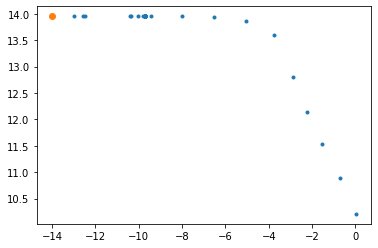

In [89]:
plt.figure()
plt.plot(lcurve_axis[1], lcurve_axis[0], '.')
plt.plot(lcurve_axis[1, np.where(lambdas==lambd)], lcurve_axis[0, np.where(lambdas==lambd)], 'o')

In [35]:
EST_CSD_LC, indx_rpLC, EE_LC, rpLC = estimate_csd(cross_reconstructor, potential,
                                        regularization_parameters=np.array([l_lambd]))

Cross validating regularization parameter : 7.278953843983146e-05


In [36]:
EST_CSD_0, indx_rp0, EE_0, rp0 = estimate_csd(cross_reconstructor, potential,
                                        regularization_parameters=np.array([0]))

Cross validating regularization parameter : 0


In [38]:
regularization_parameters = eigen_parameters
EST_CSD, indx_rp, EE, rp = estimate_csd(cross_reconstructor, potential,
                                        regularization_parameters=regularization_parameters)

Cross validating regularization parameter : 486857.06907366676
Cross validating regularization parameter : 210.94395193763853
Cross validating regularization parameter : 210.9437770639217
Cross validating regularization parameter : 28.671011866520928
Cross validating regularization parameter : 26.325007995469736
Cross validating regularization parameter : 15.700405595350443
Cross validating regularization parameter : 4.579727688505242
Cross validating regularization parameter : 4.579261164020402
Cross validating regularization parameter : 2.1242697703391036
Cross validating regularization parameter : 2.124218921458344
Cross validating regularization parameter : 0.9810236495785829
Cross validating regularization parameter : 0.7034284788106849
Cross validating regularization parameter : 0.5557024009270339
Cross validating regularization parameter : 0.27244213708071185
Cross validating regularization parameter : 0.2356507978040982
Cross validating regularization parameter : 0.159068434538

In [39]:
np.savez_compressed(save_path + '/Estimation.npz', EST_CSD_CV=EST_CSD, indx_rp=indx_rp, EE=EE,
                    LAMBD=rp, REG_PARAMS=regularization_parameters, L_LAMBD=l_lambd, LCURVE=lcurve_axis,
                    EST_CSD_0=EST_CSD_0, EE_0=EE_0, EST_CSD_LC=EST_CSD_LC, EE_LC=EE_LC)